In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

# Our labels
Below is a summary tabe of the experiments. For each file (beta(0...246) we have a label (0,1) that indicates whether the participant cooperated or ot

In [3]:
data_table_brain = pd.read_parquet("intermediate_data/data_table_brain.gzip")
beta_df = pd.read_csv("intermediate_data/beta_df.csv")
print(beta_df.shape)
beta_df.head()
# pip install fastparquet # if it doesnt work

(191, 10)


,Unnamed: 0,index,Var1,files,len,0,1,2,3,labels
0,0,0,Sn(1) choice_tr1_defect_R+S-*bf(1),beta_0001.nii,34,Sn(1) choice,tr1,defect,R+S-*bf(1),0
1,1,1,Sn(1) choice_tr2_cooperate_R+S+*bf(1),beta_0002.nii,37,Sn(1) choice,tr2,cooperate,R+S+*bf(1),1
2,2,2,Sn(1) choice_tr3_cooperate_R+S-*bf(1),beta_0003.nii,37,Sn(1) choice,tr3,cooperate,R+S-*bf(1),1
3,3,3,Sn(1) choice_tr4_defect_R-S-*bf(1),beta_0004.nii,34,Sn(1) choice,tr4,defect,R-S-*bf(1),0
4,4,4,Sn(1) choice_tr5_defect_R-S+*bf(1),beta_0005.nii,34,Sn(1) choice,tr5,defect,R-S+*bf(1),0


# Our data
Below is the table that we extracted from the fMRI images.
We converted the images to a table with x,y,z coordinates and intensity values for every voxel.
Each beta(0...246) is one trial 
One trial is around 5 images that were compressed into one image by convolution with blood oxygen level response function (BOLD)

In [4]:
print(data_table_brain.shape)
data_table_brain.head()

(41712, 196)


,index,x,y,z,brain_mask,beta0,beta1,beta2,beta3,beta4,...,beta181,beta182,beta183,beta184,beta185,beta186,beta187,beta188,beta189,beta190
0,23149,7,18,29,1.0,2.185793,0.216214,0.898458,-0.767733,0.980242,...,1.751049,2.173206,-0.770652,-0.555270,2.946541,0.775639,-0.083898,2.876902,-1.708210,-6.542468
1,23150,7,18,30,1.0,2.262514,0.176321,1.067624,-0.753252,1.558099,...,0.949927,2.077133,-1.343127,-0.579337,3.244278,2.489923,0.354420,2.482962,-1.911663,-7.082224
2,23155,7,18,35,1.0,1.409987,0.308808,1.552267,2.061087,1.836347,...,0.746239,1.372045,1.485866,3.634712,3.846372,6.075477,0.973503,0.920017,-1.207945,-4.028594
3,23156,7,18,36,1.0,0.969699,-0.110201,1.039446,2.290150,1.154906,...,1.111888,0.921008,-0.040704,2.912729,2.266409,4.096661,0.770709,1.018212,-1.520981,-1.951829
4,23229,7,20,29,1.0,1.887761,0.605765,0.851713,0.236050,1.783170,...,1.377842,1.957112,-0.367890,0.924748,2.684568,2.028383,0.284075,1.735687,-1.399973,-6.692441


### Create training data and lables


In [24]:
Xdata = np.array(data_table_brain.iloc[:,5:]).T
print(X.shape)
type(X)

(143, 41712)


numpy.ndarray

In [25]:
Ydata = np.array(beta_df["labels"])
print(Y.shape)
type(Y)

(143,)


numpy.ndarray

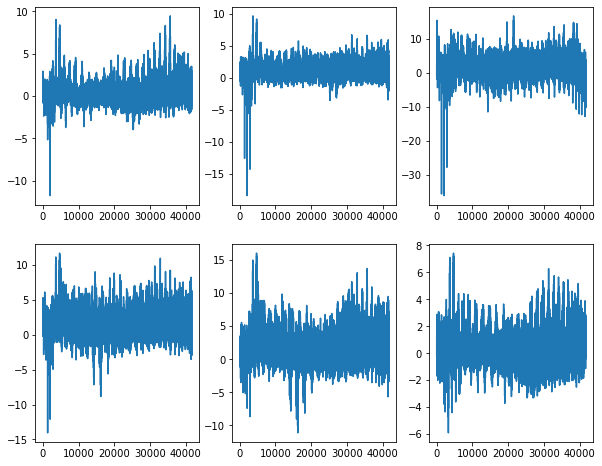

In [7]:
plt.figure(figsize=(10,8))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.plot(X[i,:])

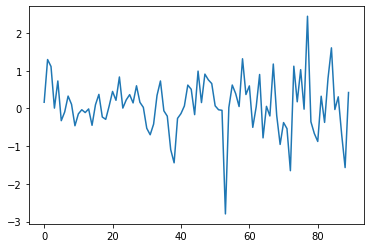

In [8]:
plt.plot(X[10:100,10])

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
import os
from scipy.stats import norm

# Random Forest on entire data
Just below is the  code we used to generate the rf predictions based on all data for one patient

In [37]:
# This is the code
clf = RandomForestClassifier(200)
acc = cross_val_score(clf, Xdata, Ydata, cv=KFold(n_splits=4, random_state=None, shuffle=False))

In [38]:
np.mean(acc)

0.5342420212765957

In [22]:
# this is just one run
X,x,Y,y = train_test_split(Xdata,Ydata)
clf = RandomForestClassifier()
clf.fit(X,Y)
y_pred = clf.predict(x)
accuracy_score(y_pred, y)

0.5208333333333334

### Dimensionality reduction
Besides training on the entire data I aso played around with PCA and training on them

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(191, 41712)

In [11]:
pca = PCA(n_components=25)
Xpca = pca.fit_transform(X)
Xpca.shape

(191, 25)

In [12]:
res = pd.DataFrame(Xpca)
res["y"] = Y

<AxesSubplot:xlabel='0', ylabel='1'>

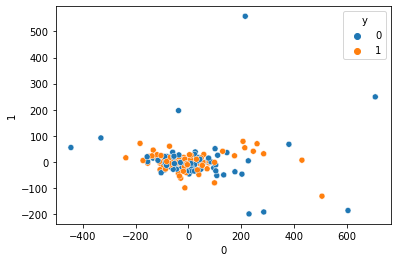

In [13]:
sns.scatterplot(data=res, x=0, y=1, hue="y")

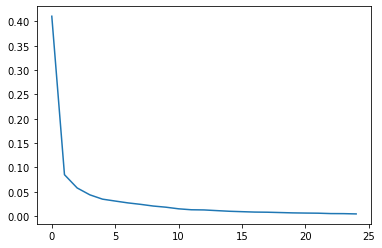

In [14]:
plt.plot(pca.explained_variance_ratio_)

## Repeat with masks

Here I use the brain atlas masks on the normalized beta images for predictions.

In [15]:
!ls masks

BN_Atlas_246_2mm.nii
TPJ_Mask.nii
output_atlas.nii


In [16]:
masks = "masks/BN_Atlas_246_2mm.nii"
files_normed = "subj02/1stLevel_nob0_norm_MVPA_trial_smooth/"
files = "subj02/1stLevel_nob0_MVPA_trial_smooth/"

In [17]:
# defining import functions for mask and nib files

def getmask(name):
    mask_im = nib.load("masks/"+name)
    mask = mask_im.get_fdata()
    return mask

def nibim(name, subj="02"):
    files_normed = f'subj{subj}/1stLevel_nob0_norm_MVPA_trial_smooth/'
    beta_path = files_normed + name
    nimage = nib.load(beta_path)
    return nimage.get_fdata()


In [18]:
# Import the atlas mask
# values are not exact int (prob because of normalization/preprocessing?)

atlasmask = getmask("output_atlas.nii")
atlasmask = atlasmask.round()
print("shape " + str(atlasmask.shape))

shape (53, 63, 52)


### Do the prediction loop

In [19]:
def mask_prediction_loop(subj="02", mode="svm", verbose=False):
    """
    This function loops over the different masks in the brain atlas mask
    For each masks it reads the data from all the beta images and performs classificaiton with svm or rf calsssifier.
    Results are written to a lof file.
    
    param subj: the subject (02 or 07)
    param mode: classifiaction mode (svm or rf (= random forest))
    """
    
    betas = pd.read_csv("intermediate_data/beta_df.csv") # these are the names of the ebta images that we use
    image_mask = getmask("output_atlas.nii")
    image_mask = image_mask.round()
    areas = set(image_mask.flatten()) # unique numbers of the mask file, each number is a different brain region
    betafiles = betas["files"].to_list()
    y_true = betas["labels"].to_list()

    # The results are written to a text file
    time_string = time.ctime().replace(" ","").replace(":","") # so we dont overwrite previous files
    log_file_name = f'subj{subj}_{mode}_result_log_{time_string}.txt'
    
    beta_files = f'subj{subj}/1stLevel_nob0_norm_MVPA_trial_smooth/'
    
    if not os.path.exists(beta_files):
        print("beta files path not found?")
        print(beta_files)
        return None
    
    with open(log_file_name, "w") as file:
        for area in areas:
            df = pd.DataFrame()
            
            for b in betafiles:
                try:
                    beta_im = nibim(b, subj)
                except FileNotFoundError:
                    print("couldnt find file: " + b)
                    continue
                subset = beta_im[image_mask==area]
                df[b] = subset
                
            # classify
            nanas = df.isna().sum().sum()
            
            if nanas>0:
                df = df.dropna()
                if verbose:
                    print("Area: "+str(area))
                    print("dropped NaNs: "+ str(nanas))

                
            if mode=="rf":
                X_train, x_test, Y_train, y_test = train_test_split(df.T,y_true)
                clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, min_samples_leaf=8)
                clf.fit(X_train, Y_train)
                y_pred = clf.predict(x_test)
                acc = accuracy_score(y_pred, y_test)

            elif mode=="svm":                   
                clf = svm.SVC(kernel='linear', C=1, random_state=42)
                acc = cross_val_score(clf, df.T, y_true, cv=KFold(n_splits=4, random_state=None, shuffle=False))
            else:
                print(f'not defined mode {mode}')

            if verbose:
                print(acc)

            file.write(f'Area, {area}, Accuracy, {acc}\n')
                
    return None
                
                

In [149]:
# mask_prediction_loop(subj="02", mode="svm", verbose=False)
# mask_prediction_loop(subj="07", mode="svm", verbose=True)
#data analysis in other notebook